# Purpose:
- Calculate clustering index CHANGE between sessions, using matched cells.
- First, need to characterize matching cells
    - Are they more fit compared to non-matching cells between sessions?
    - Are they more active? 
        - How can I define activeness? Number of frames larger than noise level?
            - Larger than MAD
- What is the pattern of touch encoding and tuning amplitude change between matched cells?


In [2]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.optimize import linear_sum_assignment
import utils.clustering_index as ci
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import os
import socket
host_name = socket.gethostname()
if host_name == 'HNB228-LABPC6':
    base_dir = Path(r'D:\JK\h5')
elif host_name == 'hnb228-jinho':
    # base_dir = Path(r'E:\TPM\JK\h5')
    base_dir = Path(r'C:\JK')
else:
    raise('Incorrect computer')

results_dir = base_dir / 'results'
# wf_dir = results_dir / 'touch_whisker_features'
# b_dir = Path(r'E:\TPM\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]').copy()
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'
roi_matching_dir = results_dir / 'roi_matching'

touch_dir = results_dir / 'touch_tuning'
glm_dir = results_dir / 'neuron_glm/ridge/touch_combined'

# Check IDs
- viable_cell_index from master_roi and cell_id from glm_results
- they all match
    - IDs from glm that are not in viable_cell_index: removed due to FOV QC and match
    - IDs from viable_cell_index that are not in glm: removed due to dendrite filtering

In [ ]:
mouse = 25
plane = 1
master_roi_fn = roi_matching_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

roi_matching_fn = roi_matching_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_matching = np.load(roi_matching_fn, allow_pickle=True).item()

for si in range(len(master_roi['session_nums'])):
    session = master_roi['session_nums'][si]
    assert len(roi_matching['matching_master_roi_index_list'][si]) == len(master_roi['viable_cell_index_list'][si])
    glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
    with xr.open_dataset(glm_fn) as glm_result:
        glm_result.load()
    num_roi_diff = len(master_roi['viable_cell_index_list'][si]) - glm_result.cell_id.size
    print(f'Session {session}: {num_roi_diff} difference between roi and glm result')
    not_in_glm = len(np.where(np.isin(master_roi['viable_cell_index_list'][si], glm_result.cell_id.values)==0)[0])
    print(f'{not_in_glm} cells not in GLM')

In [62]:
# check if those not in GLM are dendrites
diameter_threshold = 7
def pix_to_eq_diameter(npix, pix_size):
    return np.sqrt(npix/np.pi) * 2 * pix_size

for mouse in mice[-1:]:
    for plane in range(1,9):
        print(f'Processing mouse {mouse} plane {plane}')
        master_roi_fn = roi_matching_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
        master_roi = np.load(master_roi_fn, allow_pickle=True).item()
        for si in range(len(master_roi['session_nums'])):
            session = master_roi['session_nums'][si]
            data_dir = Path(r'F:\\') if mouse < 31 else Path(r'D:')
            roi_dir = data_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
            try:
                iscell = np.load(roi_dir / 'iscell.npy')
            except:
                print(f'No iscell.npy file for JK{mouse:03} plane {plane} session {session}')
                continue
            stat = np.load(roi_dir / 'stat.npy', allow_pickle=True)

            ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
            pix_size = ops['umPerPix']

            glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
            if os.path.isfile(glm_fn) == False:
                print(f'No GLM result file for JK{mouse:03} plane {plane} session {session}')
                continue
            with xr.open_dataset(glm_fn) as glm_result:
                glm_result.load()
            not_in_glm_ind_vci = np.where(np.isin(master_roi['viable_cell_index_list'][si], glm_result.cell_id.values)==0)[0]
            not_in_glm_ind = master_roi['viable_cell_index_list'][si][not_in_glm_ind_vci]

            assert iscell[not_in_glm_ind,0].any() == False
            assert np.array([pix_to_eq_diameter(stat[i]['npix'],pix_size) < diameter_threshold for i in not_in_glm_ind]).all()

# Takes about 14 min

Processing mouse 52 plane 1
No GLM result file for JK052 plane 1 session 7
Processing mouse 52 plane 2
No GLM result file for JK052 plane 2 session 7
Processing mouse 52 plane 3
No GLM result file for JK052 plane 3 session 7
Processing mouse 52 plane 4
No GLM result file for JK052 plane 4 session 7
Processing mouse 52 plane 5
Processing mouse 52 plane 6
Processing mouse 52 plane 7
Processing mouse 52 plane 8


# Make ROI ind mapping to master ROIs
- For all sessions that were registered
- Save them to a single pkl file
- Master ROI ID: {mouse ID:03} + 'mr' + 4 digit, starting with plane number
    - vs session ROI: {mouse ID:03} + 's{session_num:02}' + 4 digit, starting with plane number

In [79]:
# Takes about 4.5 min
roi_mapping_df = pd.DataFrame(columns=['master_roi_id', 'session_roi_id'])
for mouse in mice:
    for plane in range(1,9):
        master_roi_fn = roi_matching_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
        master_roi = np.load(master_roi_fn, allow_pickle=True).item()

        roi_matching_fn = roi_matching_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
        roi_matching = np.load(roi_matching_fn, allow_pickle=True).item()

        for si in range(len(master_roi['session_nums'])):
            session = master_roi['session_nums'][si]
            mr_vci = master_roi['viable_cell_index_list'][si]
            mr_roi_ind = roi_matching['matching_master_roi_index_list'][si]

            master_roi_id = [f'{mouse:03}mr{plane}{mr_roi_ind[i]:03}' for i in range(len(mr_roi_ind))]
            session_roi_id = [f'{mouse:03}s{session:02}_{plane}{mr_vci[i]:03}' for i in range(len(mr_vci))]
            roi_mapping_df = roi_mapping_df.append(pd.DataFrame({'master_roi_id':master_roi_id, 'session_roi_id':session_roi_id}))

In [81]:
save_fn = roi_matching_dir / 'roi_mapping.pkl'
roi_mapping_df.to_pickle(save_fn)

In [82]:
roi_mapping_df.head()

,master_roi_id,session_roi_id
0,025mr1090,025s01_1001
1,025mr1104,025s01_1002
2,025mr1000,025s01_1003
3,025mr1092,025s01_1004
4,025mr1214,025s01_1005


In [95]:
roi_mapping_df.session_roi_id.values[0]

'025s01_1001'

## QC again on this match

In [27]:
roi_mapping_fn = roi_matching_dir / 'roi_mapping.pkl'
roi_mapping_df = pd.read_pickle(roi_mapping_fn)

mouse = 27
data_dir = Path('F:') if mouse < 31 else Path('D:')

plane = 3
master_roi_ids = roi_mapping_df[roi_mapping_df.master_roi_id.str.contains(f'{mouse:03}mr{plane}')].master_roi_id.unique()
len(master_roi_ids)

384

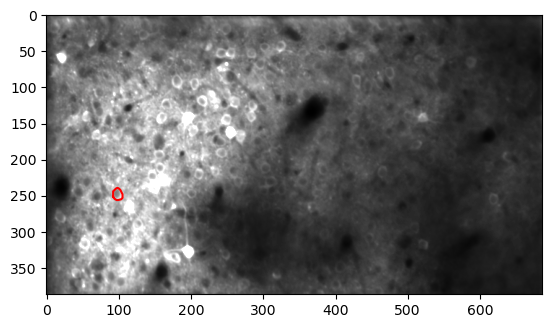

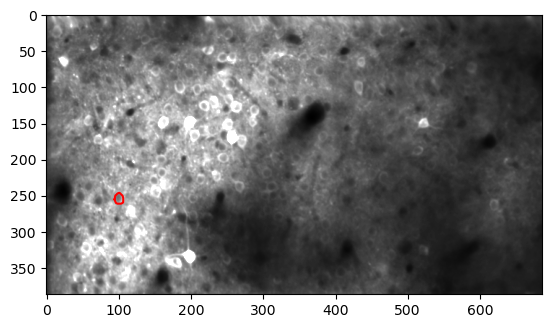

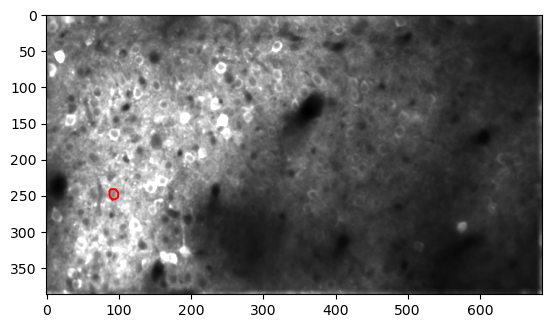

In [28]:
from scipy.spatial import ConvexHull

temp_mrid = master_roi_ids[56]
temp_srid = roi_mapping_df.query(f'master_roi_id=="{temp_mrid}"').session_roi_id.values
sessions = [int(srid.split('s')[1][:2]) for srid in temp_srid]
for si, session in enumerate(sessions):

    roi_dir = data_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    mimg = ops['meanImg']
    stat = np.load(roi_dir / 'stat.npy', allow_pickle=True)

    session_roi_ind = int(temp_srid[si][-3:])
    session_roi = stat[session_roi_ind]

    points = np.array([session_roi['xpix'], session_roi['ypix']]).T
    hull = ConvexHull(points)
    hull_path = np.append(hull.vertices, hull.vertices[0])

    fig, ax = plt.subplots()
    ax.imshow(mimg, cmap='gray', vmax=np.percentile(mimg.flatten(), 99))
    # draw contour of session_roi
    ax.plot(points[hull_path, 0], points[hull_path, 1], 'r-')


In [20]:
points.shape

(2, 235)

In [16]:
session_roi['xpix']

array([435, 436, 437, 438, 433, 434, 435, 436, 437, 438, 439, 440, 432,
       433, 434, 435, 436, 437, 438, 439, 440, 441, 432, 433, 434, 435,
       436, 437, 438, 439, 440, 441, 442, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 431, 432, 433, 434, 435,
       436, 437, 438, 439, 440, 441, 442, 443, 444, 431, 432, 433, 434,
       435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 432, 433, 434,
       435, 436, 437, 438, 439, 440, 441, 442, 443, 432, 433, 434, 435,
       436, 437, 438, 439, 440, 441, 442, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 435, 436, 437, 438, 439, 440, 441, 439],
      dtype=int64)

# Find matched cells and run clustering index
- Options:
    - Using all matched
    - Using fit in either
    - Using fit in both
- Run ROI ID conversion
    - From now on, all session-specific ROIs have unique ID
    - 240511_roi_id_conversion.ipynb
    - Do this for all the future data, and retrospectively change them

## First between 2 sessions

In [116]:
roi_mapping_fn = roi_matching_dir / 'roi_mapping.pkl'
roi_mapping_df = pd.read_pickle(roi_mapping_fn)

mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query(f'mouse=={mouse} and volume=={volume}').session.values]
si_comp = [0,1]

# First, get matched ROIs
for si in range(len(si_comp)):
    sic = si_comp[si]
    session = sessions[sic]

    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr']

    session_ids = response_xr.cell_id.values
    session_mr_ids = roi_mapping_df.query('session_roi_id in @session_ids').master_roi_id.values
    if si == 0:
        matched_mr_ids = session_mr_ids
    else:
        matched_mr_ids = np.intersect1d(matched_mr_ids, session_mr_ids)

    response_xr_fit = touch_response_results['per_touch_response_xr_fit']
    session_ids_fit = response_xr_fit.cell_id.values
    session_mr_ids_fit = roi_mapping_df.query('session_roi_id in @session_ids_fit').master_roi_id.values
    if si == 0:
        matched_mr_ids_fit_both = session_mr_ids_fit
        matched_mr_ids_fit_either = session_mr_ids_fit
    else:
        matched_mr_ids_fit_both = np.intersect1d(matched_mr_ids_fit_both, session_mr_ids_fit)
        matched_mr_ids_fit_either = np.union1d(matched_mr_ids_fit_either, session_mr_ids_fit)

matched_session_ids = roi_mapping_df.query('master_roi_id in @matched_mr_ids')
matched_session_ids_fit_both = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_both')
matched_session_ids_fit_either = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_either')
# Then, match back to each session
# and collect response_df and response_xr (or_fit)
response_df_matched = []
response_xr_matched = []
response_xr_fit_both_matched = []
response_xr_fit_either_matched = []
for si in range(len(si_comp)):
    sic = si_comp[si]
    session = sessions[sic]
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()

    response_df = touch_response_results['per_touch_response_df']
    response_df_matched.append(response_df)
        
    response_xr = touch_response_results['per_touch_response_xr']
    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids))[0]                                                    
    response_xr = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
    response_xr_matched.append(response_xr)

    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_both))[0]
    response_xr_fit_both = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
    response_xr_fit_both_matched.append(response_xr_fit_both)

    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_either))[0]
    response_xr_fit_either = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
    response_xr_fit_either_matched.append(response_xr_fit_either)



In [129]:
roi_mapping_fn = roi_matching_dir / 'roi_mapping.pkl'
roi_mapping_df = pd.read_pickle(roi_mapping_fn)
num_dims = 7

mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query(f'mouse=={mouse} and volume=={volume}').session.values]
si_comp = [0,1]

# First, get matched ROIs
for si in range(len(si_comp)):
    sic = si_comp[si]
    session = sessions[sic]

    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr']

    session_ids = response_xr.cell_id.values
    session_mr_ids = roi_mapping_df.query('session_roi_id in @session_ids').master_roi_id.values
    if si == 0:
        matched_mr_ids = session_mr_ids
    else:
        matched_mr_ids = np.intersect1d(matched_mr_ids, session_mr_ids)

    response_xr_fit = touch_response_results['per_touch_response_xr_fit']
    session_ids_fit = response_xr_fit.cell_id.values
    session_mr_ids_fit = roi_mapping_df.query('session_roi_id in @session_ids_fit').master_roi_id.values
    if si == 0:
        matched_mr_ids_fit_both = session_mr_ids_fit
        matched_mr_ids_fit_either = session_mr_ids_fit
    else:
        matched_mr_ids_fit_both = np.intersect1d(matched_mr_ids_fit_both, session_mr_ids_fit)
        matched_mr_ids_fit_either = np.union1d(matched_mr_ids_fit_either, session_mr_ids_fit)

matched_session_ids = roi_mapping_df.query('master_roi_id in @matched_mr_ids')
matched_session_ids_fit_both = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_both')
matched_session_ids_fit_either = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_either')
# Then, match back to each session
# and compute clustering index
ci_matched = []
ci_fit_either_matched = []
ci_fit_both_matched = []
for si in range(len(si_comp)):
    sic = si_comp[si]
    session = sessions[sic]
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()

    response_df = touch_response_results['per_touch_response_df']
            
    response_xr = touch_response_results['per_touch_response_xr']
    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids))[0]                                                    
    response_xr = response_xr.isel(cell_id=session_ids_mr_matchback_ind)    
    ci_matched.append(ci.calculate_clustering_index(response_xr,
                                                    response_df, num_dims=num_dims))

    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_either))[0]
    response_xr_fit_either = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
    ci_fit_either_matched.append(ci.calculate_clustering_index(response_xr_fit_either,
                                                               response_df, num_dims=num_dims))

    session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_both))[0]
    response_xr_fit_both = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
    ci_fit_both_matched.append(ci.calculate_clustering_index(response_xr_fit_both,
                                                             response_df, num_dims=num_dims))
    


In [149]:
def get_ci_from_matched_rois(mouse, volume, session_nums_comp,
                             num_dims=7, num_repeat=500):
    # roi_matching_dir
    # pop_res_dir

    roi_mapping_fn = roi_matching_dir / 'roi_mapping.pkl'
    roi_mapping_df = pd.read_pickle(roi_mapping_fn)

    # First, get matched ROIs
    for si, session in enumerate(session_nums_comp):
        touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
        touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
        response_xr = touch_response_results['per_touch_response_xr']

        session_ids = response_xr.cell_id.values
        session_mr_ids = roi_mapping_df.query('session_roi_id in @session_ids').master_roi_id.values
        if si == 0:
            matched_mr_ids = session_mr_ids
        else:
            matched_mr_ids = np.intersect1d(matched_mr_ids, session_mr_ids)

        response_xr_fit = touch_response_results['per_touch_response_xr_fit']
        session_ids_fit = response_xr_fit.cell_id.values
        session_mr_ids_fit = roi_mapping_df.query('session_roi_id in @session_ids_fit').master_roi_id.values
        if si == 0:
            matched_mr_ids_fit_both = session_mr_ids_fit
            matched_mr_ids_fit_either = session_mr_ids_fit
        else:
            matched_mr_ids_fit_both = np.intersect1d(matched_mr_ids_fit_both, session_mr_ids_fit)
            matched_mr_ids_fit_either = np.union1d(matched_mr_ids_fit_either, session_mr_ids_fit)

    matched_session_ids = roi_mapping_df.query('master_roi_id in @matched_mr_ids')
    matched_session_ids_fit_both = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_both')
    matched_session_ids_fit_either = roi_mapping_df.query('master_roi_id in @matched_mr_ids_fit_either')
    # Then, match back to each session
    # and compute clustering index
    ci_matched = []
    ci_fit_either_matched = []
    ci_fit_both_matched = []
    for session in session_nums_comp:
        touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
        touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()

        response_df = touch_response_results['per_touch_response_df']
                
        response_xr = touch_response_results['per_touch_response_xr']
        session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids))[0]                                                    
        response_xr = response_xr.isel(cell_id=session_ids_mr_matchback_ind)    
        ci_matched.append(ci.calculate_clustering_index(response_xr, response_df,
                                                        num_dims=num_dims, num_repeat=num_repeat))

        session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_either))[0]
        response_xr_fit_either = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
        ci_fit_either_matched.append(ci.calculate_clustering_index(response_xr_fit_either, response_df,
                                                                   num_dims=num_dims, num_repeat=num_repeat))

        session_ids_mr_matchback_ind = np.where(np.isin(response_xr.cell_id.values, matched_session_ids_fit_both))[0]
        response_xr_fit_both = response_xr.isel(cell_id=session_ids_mr_matchback_ind)
        ci_fit_both_matched.append(ci.calculate_clustering_index(response_xr_fit_both, response_df,
                                                                 num_dims=num_dims, num_repeat=num_repeat))
    return matched_mr_ids, matched_mr_ids_fit_either, matched_mr_ids_fit_both, \
        ci_matched, ci_fit_either_matched, ci_fit_both_matched


In [152]:
# Looking at the ci variation
# Takes about 6 min
for i in range(5):
    matched_mr_ids, matched_mr_ids_fit_either, matched_mr_ids_fit_both, \
        ci_matched, ci_fit_either_matched, ci_fit_both_matched = \
            get_ci_from_matched_rois(25, 1, [1,2], num_repeat=10000)
    print(ci_matched)

[0.2272088348028632, 0.15732585645480326]
[0.22740847380725904, 0.15611630591137213]
[0.22711693384425352, 0.15780359741057146]
[0.22670773219551588, 0.15583064511016068]
[0.22755245376109146, 0.15649345749196164]


## Run in multiprocessing

In [163]:
comp_snum_df = pd.DataFrame(columns=['mouse', 'volume', 'session_nums_comp'])
sessions = [int(s) for s in training_volume_df.query('mouse==@mouse and volume==@volume').session.values]

for si in range(len(sessions)-1):
    for sj in range(si+1, len(sessions)):
        temp_df = pd.DataFrame({'mouse': mouse,
                                'volume': volume,
                                'session_nums_comp': [np.array([sessions[si], sessions[sj]])],
                                })
        comp_snum_df = comp_snum_df.append(temp_df)


In [171]:
comp_snum_df = pd.DataFrame(columns=['mouse', 'volume', 'session_nums_comp'])
for mouse in training_volume_df.mouse.unique():
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query('mouse==@mouse and volume==@volume').session.values]
        for si in range(len(sessions)-1):
            for sj in range(si+1, len(sessions)):
                temp_df = pd.DataFrame({'mouse': mouse,
                                        'volume': volume,
                                        'session_nums_comp': [np.array([sessions[si], sessions[sj]])],
                                        })
                comp_snum_df = comp_snum_df.append(temp_df)
print(len(comp_snum_df))

913


In [173]:
913/18*2

101.44444444444444

In [156]:
ci_matched_training_dir = results_dir / 'clustering_index_matched_roi' / 'training_sessions'
load_fn = ci_matched_training_dir / 'JK025_volume1_ci_matched_01_02.pkl'
temp_df = pd.read_pickle(load_fn)

## Analyze pairwise CI comparison